In [ ]:
%%capture
!pip install etna[all] -U

In [ ]:
import torch
import random

import pandas as pd
import numpy as np

from etna.datasets.tsdataset import TSDataset
from etna.pipeline import Pipeline
from etna.transforms import DateFlagsTransform, LagTransform, LinearTrendTransform, StandardScalerTransform
from etna.metrics import SMAPE, MAPE, MAE
from etna.analysis import plot_backtest
from etna.models import SeasonalMovingAverageModel
from etna.models.nn import DeepARModel, RNNModel
from etna.models.nn.utils import PytorchForecastingDatasetBuilder

from pytorch_forecasting.data import GroupNormalizer

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def set_seed(seed: int = 2024):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [ ]:
set_seed()

In [ ]:
df = pd.read_csv('example_dataset.csv')
df.head()

,timestamp,segment,target
0,2019-01-01,segment_a,170
1,2019-01-02,segment_a,243
2,2019-01-03,segment_a,267
3,2019-01-04,segment_a,287
4,2019-01-05,segment_a,279


In [ ]:
df = TSDataset.to_dataset(df)
ts = TSDataset(df, freq='D')
ts.head()

segment,segment_a,segment_b,segment_c,segment_d
feature,target,target,target,target
timestamp,,,,
2019-01-01,170,102,92,238
2019-01-02,243,123,107,358
2019-01-03,267,130,103,366
2019-01-04,287,138,103,385
2019-01-05,279,137,104,384


In [ ]:
HORIZON = 7

## RNN

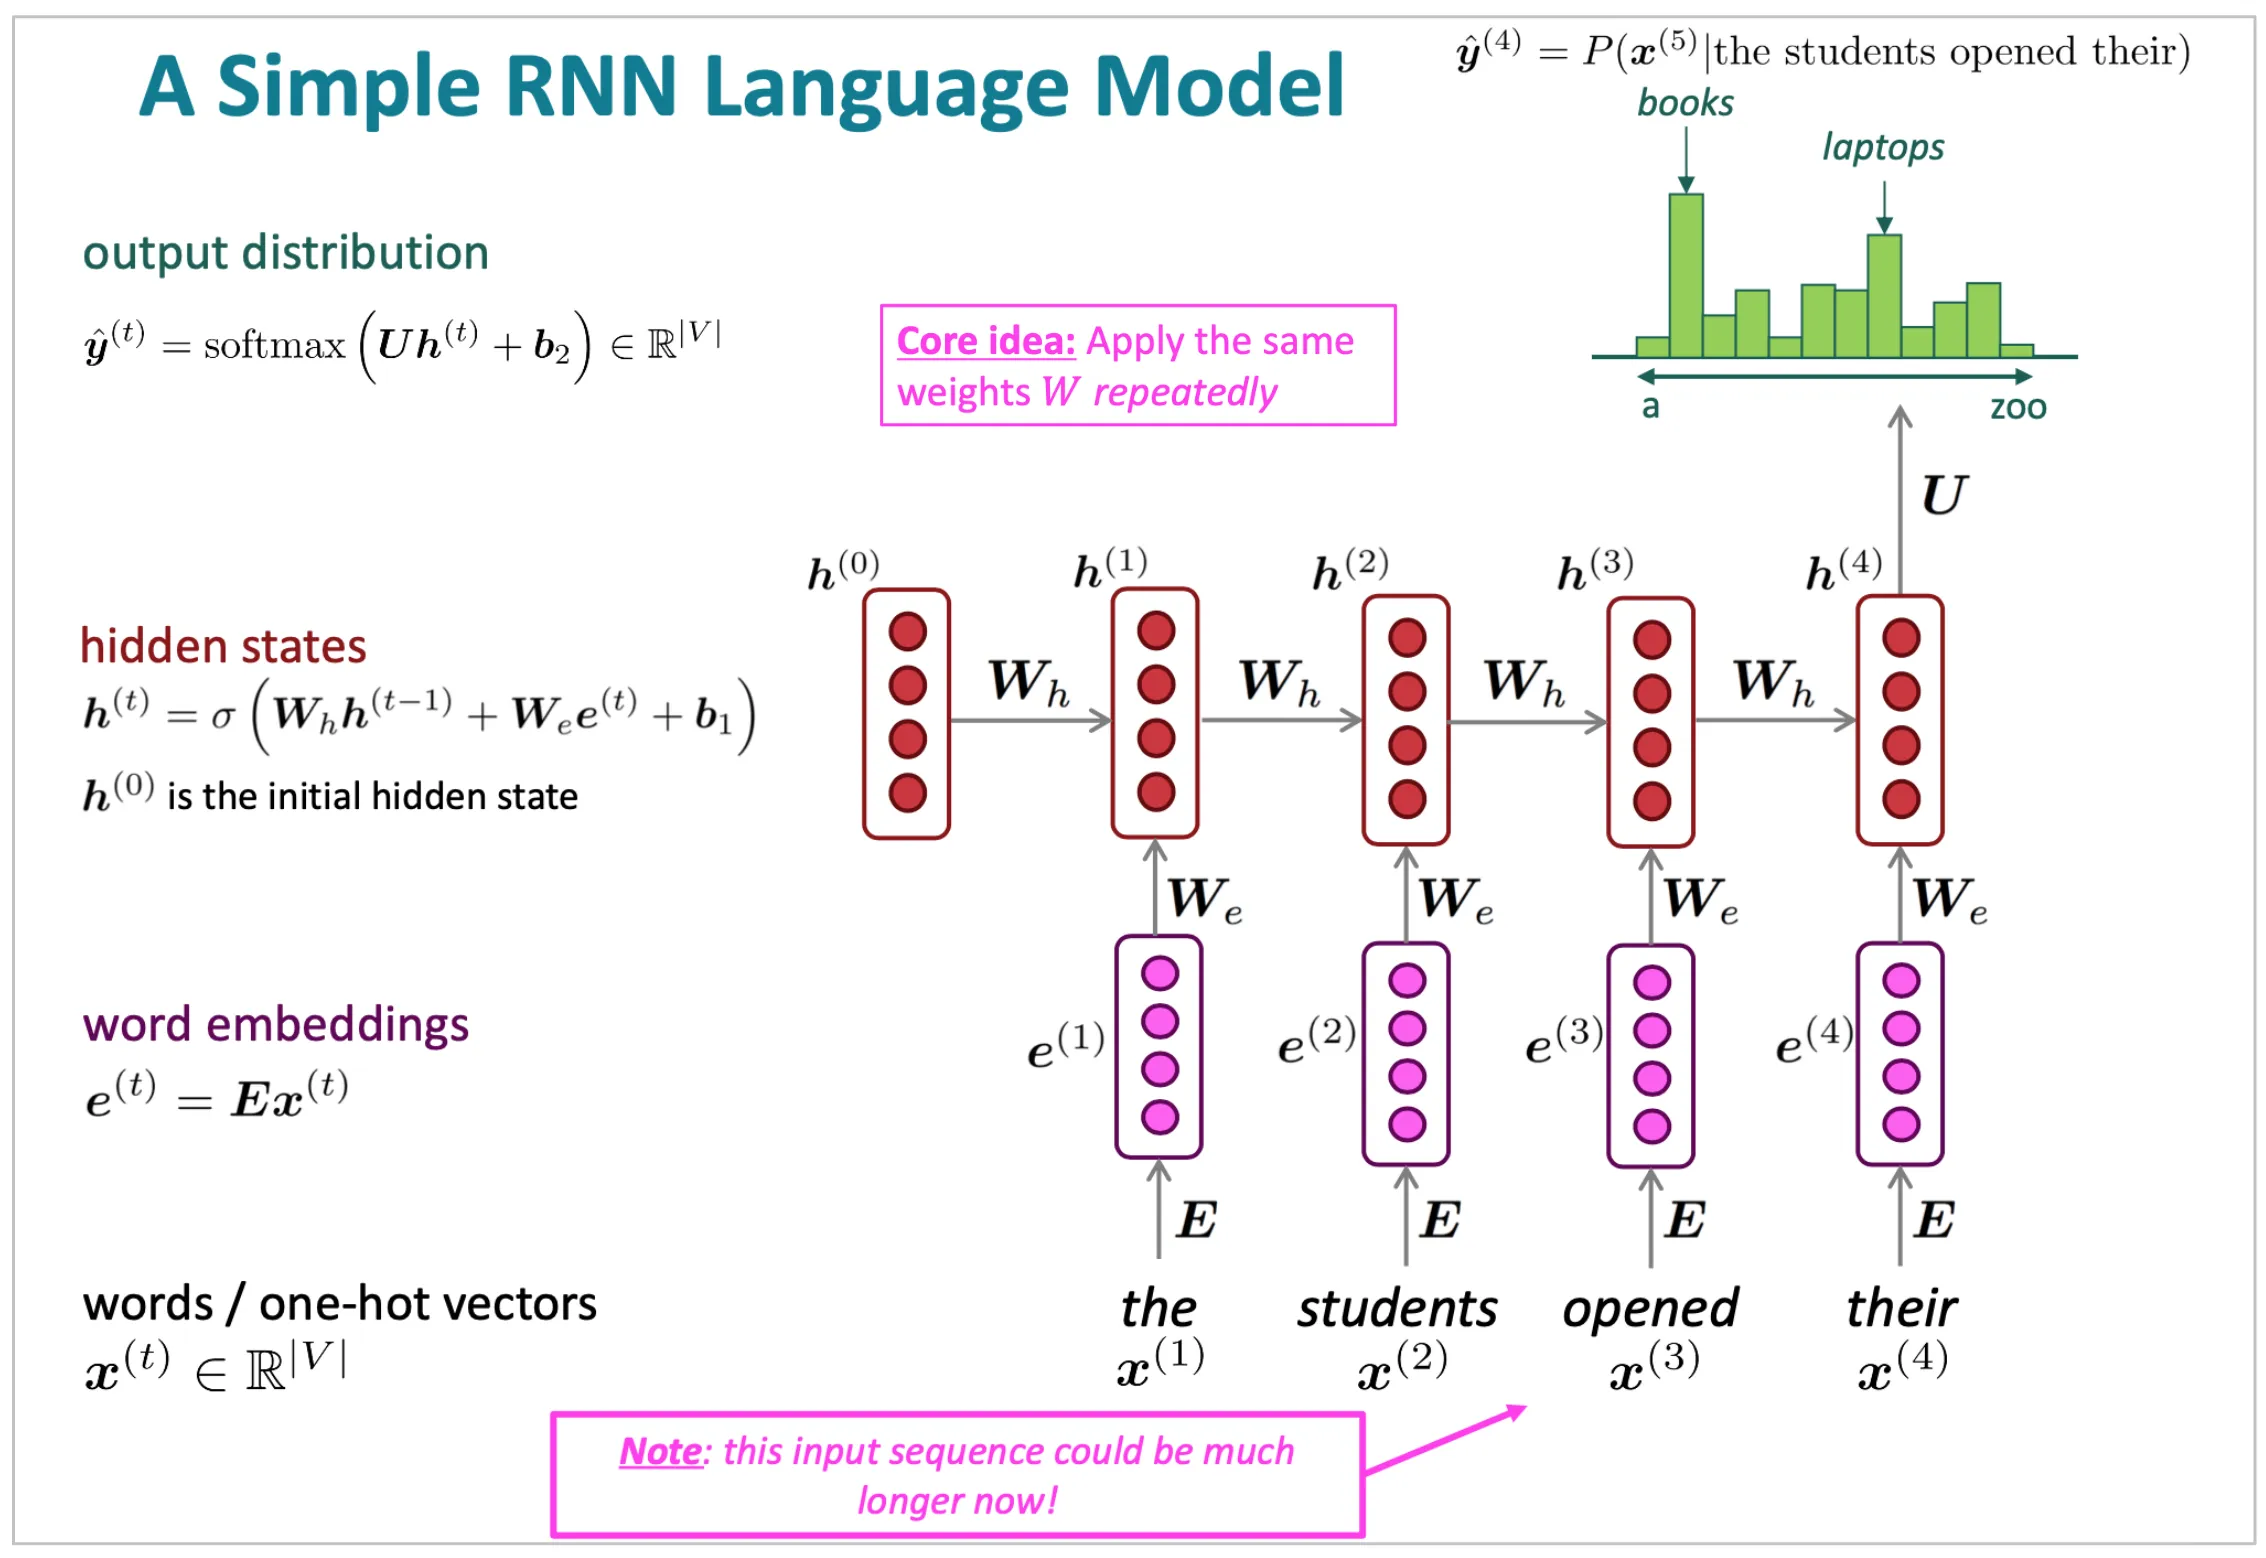

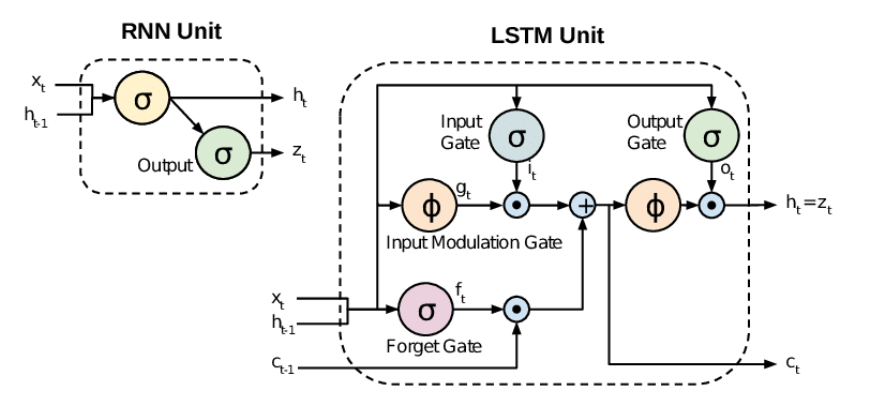

In [ ]:
model_rnn = RNNModel(
    decoder_length=HORIZON,
    encoder_length=2 * HORIZON,
    input_size=11,
    trainer_params=dict(max_epochs=5),
    lr=1e-3,
)

pipeline_rnn = Pipeline(
    model=model_rnn,
    horizon=HORIZON,
    transforms=[StandardScalerTransform(in_column="target"), transform_lag],
)

In [ ]:
metrics_rnn, forecast_rnn, fold_info_rnn = pipeline_rnn.backtest(ts, metrics=metrics, n_folds=3, n_jobs=1)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type    | Params
---------------------------------------
0 | loss       | MSELoss | 0     
1 | rnn        | LSTM    | 4.0 K 
2 | projection | Linear  | 17    
---------------------------------------
4.0 K     Trainable params
0         Non-trainable params
4.0 K     Total params
0.016     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   11.9s
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type    | Params
---------------------------------------
0 | loss       | MSELoss | 0     
1 | rnn        | LSTM    | 4.0 K 
2 | projection | Linear  | 17    
---------------------------------------
4.0 K     Trainable params
0         Non-trainable params
4.0 K     Total params
0.016     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   23.1s
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type    | Params
---------------------------------------
0 | loss       | MSELoss | 0     
1 | rnn        | LSTM    | 4.0 K 
2 | projection | Linear  | 17    
---------------------------------------
4.0 K     Trainable params
0         Non-trainable params
4.0 K     Total params
0.016     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   34.8s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   34.8s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.2s


In [ ]:
score = metrics_rnn["SMAPE"].mean()
print(f"Усредненное значение SMAPE для LSTM: {score:.3f}")

Усредненное значение SMAPE для LSTM: 6.187


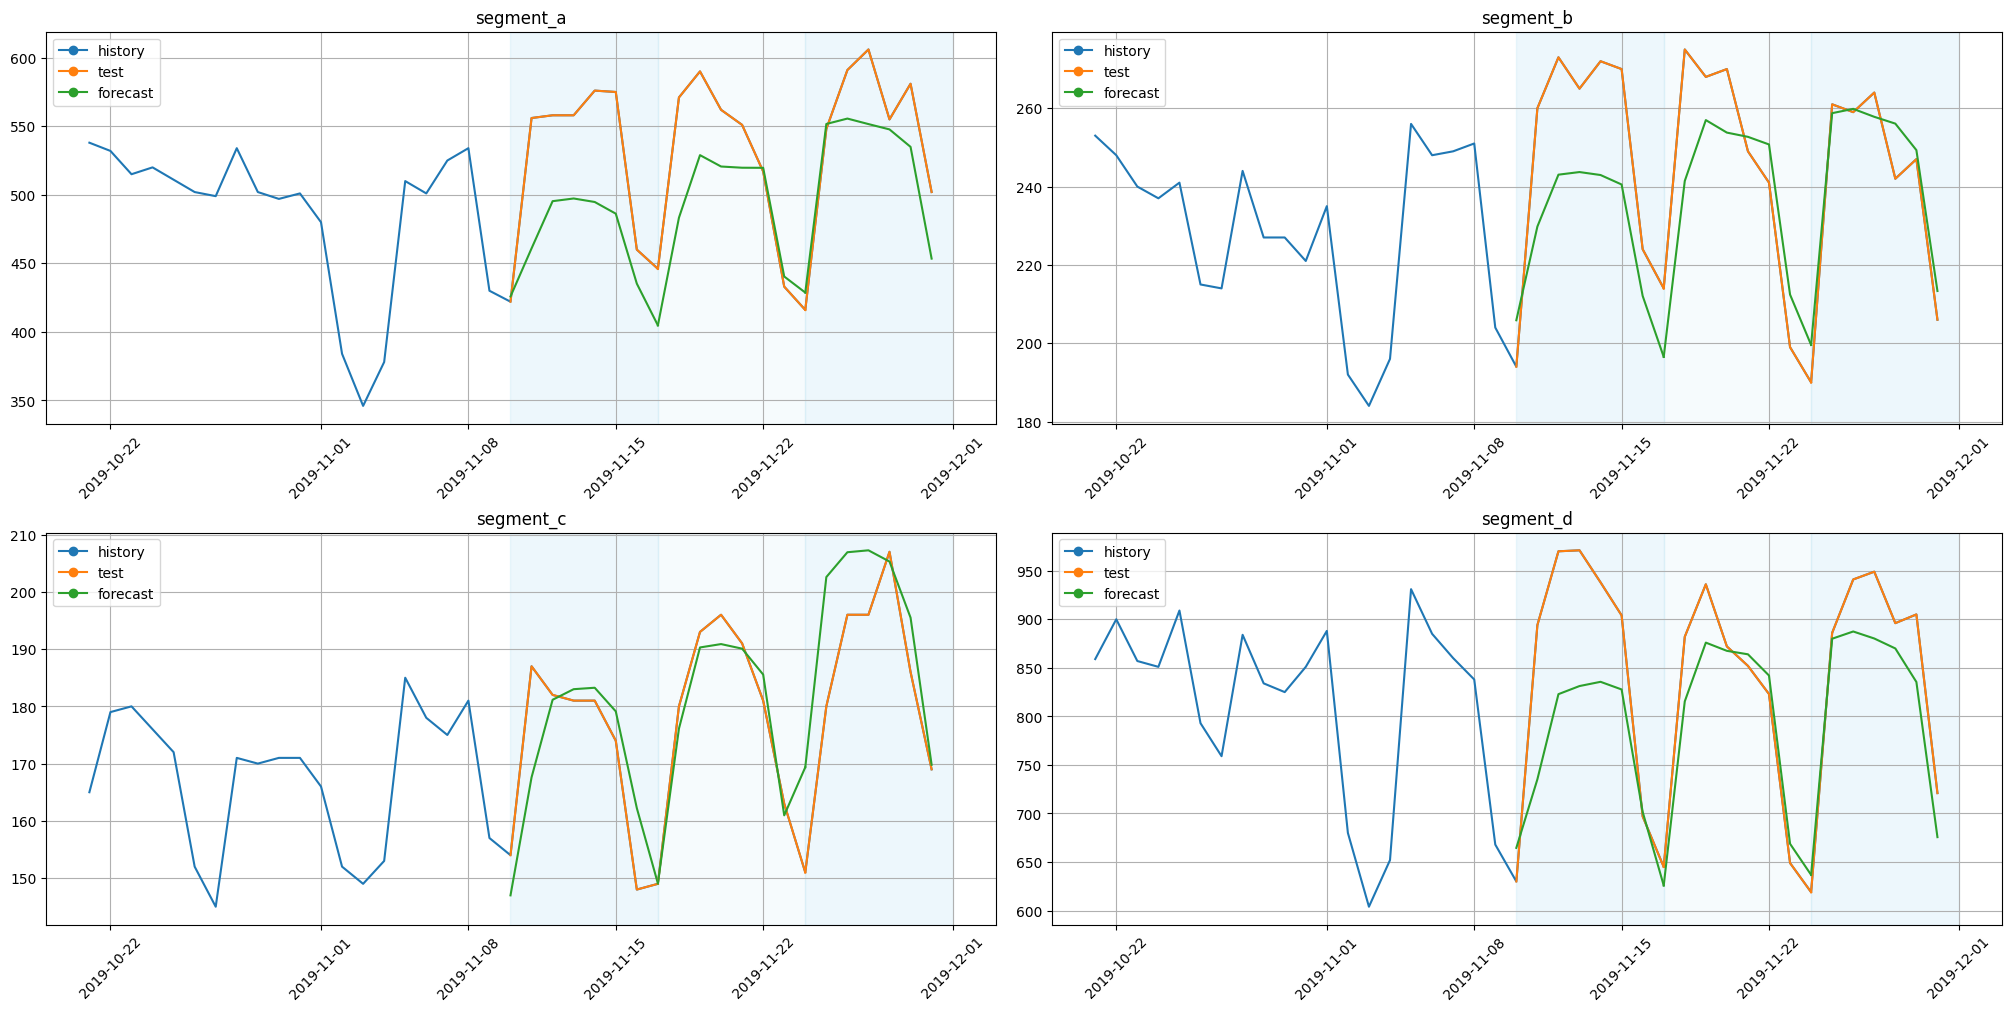

In [ ]:
plot_backtest(forecast_rnn, ts, history_len=20)

## DeepAR (deep auto regression)

[DeepAR: Probabilistic Forecasting with Autoregressive Recurrent Networks](https://arxiv.org/abs/1704.04110)

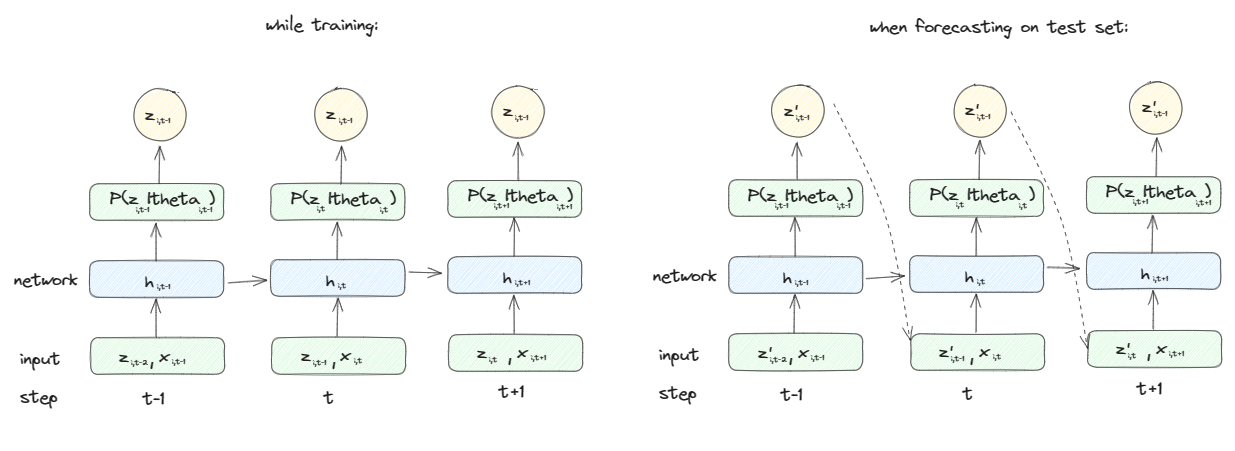



*   Модель состоит из нескольких рекуррентных блоков
*   На каждом временном шаге мы передаем в ячейку не только значение скрытого слоя с предыдущего шага(как в обычных рекуррентных сетях), но и предыдущее значение временного ряда/прогноз с предыдущего шага (во время обучения/прогноза на тесте)
*   Модель учится предсказывать не действительное значение временного ряда, а параметры распределения значений временного ряда таким образом, чтобы максимизировать правдоподобие полученной выборки. В качестве прогноза берем среднее значение полученного распределения




### Vanilla

In [ ]:
model_deepar = DeepARModel(
    encoder_length=HORIZON, # длина истории, исходя из которой модель будет строить признаки
    decoder_length=HORIZON, # горизонт прогнозирования
    trainer_params=dict(
        max_epochs=150,
        gradient_clip_val=0.1,
    ),
    lr=0.01,
    train_batch_size=64,
)

# задаем метрики
metrics = [SMAPE(), MAPE(), MAE()]

pipeline_deepar = Pipeline(model=model_deepar, horizon=HORIZON)

In [ ]:
metrics_deepar, forecast_deepar, _ = pipeline_deepar.backtest(
    ts,
    metrics=metrics,
    n_folds=3,
    n_jobs=1,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 0     
3 | rnn                    | LSTM                   | 1.6 K 
4 | distribution_projector | Linear                 | 22    
------------------------------------------------------------------
1.6 K     Trainable params
0         Non-trainable params
1.6 K     Total params
0.006     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  4.9min
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 0     
3 | rnn                    | LSTM                   | 1.6 K 
4 | distribution_projector | Linear                 | 22    
-----------------------------------------------

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:  9.3min
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 0     
3 | rnn                    | LSTM                   | 1.6 K 
4 | distribution_projector | Linear                 | 22    
-----------------------------------------------

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed: 14.1min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed: 14.1min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.2s


In [ ]:
metrics_deepar

,segment,SMAPE,MAPE,MAE,fold_number
0,segment_a,7.949946,7.499622,40.712995,0
0,segment_a,3.239189,3.311342,16.632616,1
0,segment_a,6.922781,6.804295,35.940369,2
1,segment_b,8.305842,7.826897,20.448414,0
1,segment_b,5.517057,5.517509,13.205139,1
1,segment_b,4.134099,4.292745,9.263184,2
2,segment_c,6.099553,5.949111,10.401524,0
2,segment_c,5.365157,5.256915,9.332432,1
2,segment_c,12.158371,11.541890,21.425195,2
3,segment_d,7.592220,7.368386,63.750811,0


In [ ]:
score = metrics_deepar['SMAPE'].mean()
print(f"Усредненное значение SMAPE для DeepAR: {score:.3f}")

Усредненное значение SMAPE для DeepAR: 6.488


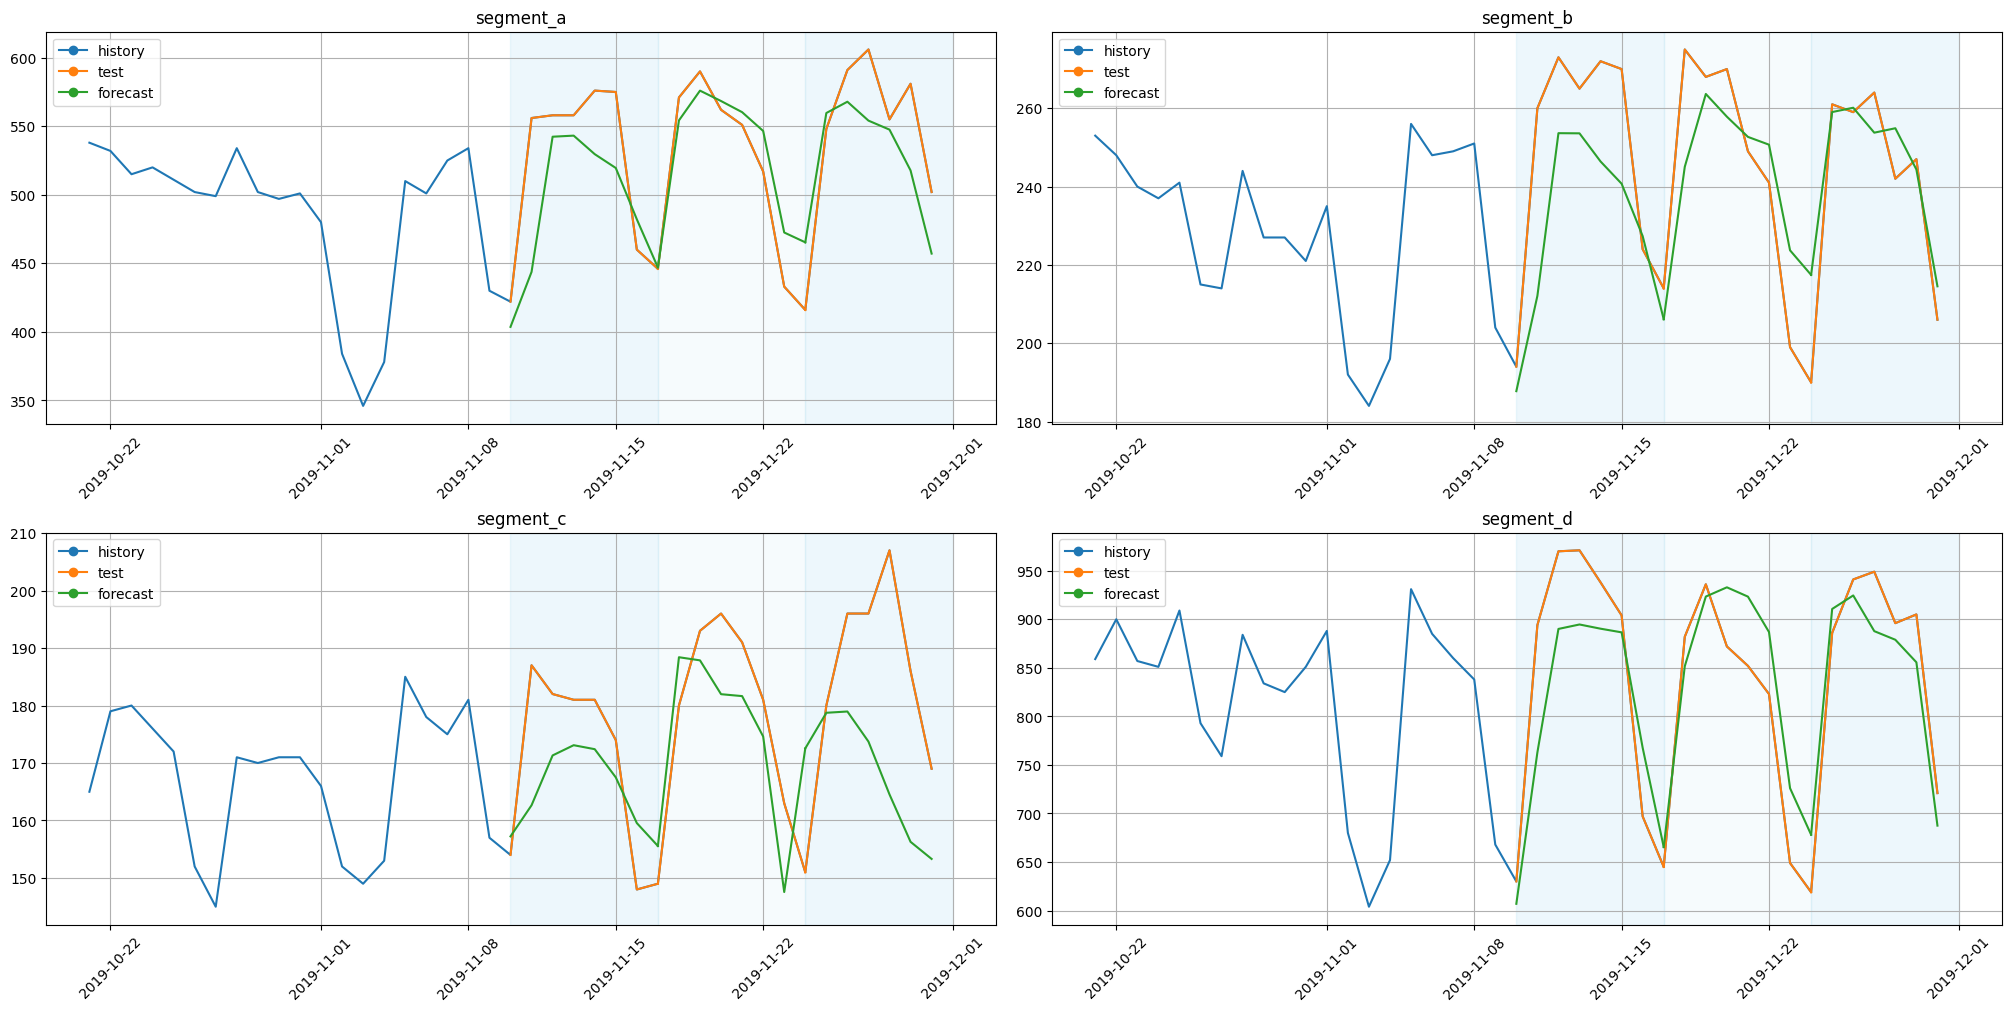

In [ ]:
plot_backtest(forecast_deepar, ts, history_len=20)

### DeepAR + FE

In [ ]:
transform_date = DateFlagsTransform(
    day_number_in_week=True,
    day_number_in_month=False,
    out_column='dateflag'
)

num_lags = 10
transform_lag = LagTransform(
    in_column='target',
    lags=[HORIZON + i for i in range(num_lags)],
    out_column='target_lag'
)
lag_columns = [f'target_lag_{HORIZON+i}' for i in range(num_lags)]

In [ ]:
dataset_builder_deepar = PytorchForecastingDatasetBuilder(
    max_encoder_length=HORIZON,
    max_prediction_length=HORIZON,
    time_varying_known_reals=['time_idx'] + lag_columns,
    time_varying_unknown_reals=['target'],
    time_varying_known_categoricals=['dateflag_day_number_in_week'],
    target_normalizer=GroupNormalizer(groups=['segment']),
)

In [ ]:
model_deepar = DeepARModel(
    dataset_builder=dataset_builder_deepar,
    trainer_params=dict(max_epochs=150, gpus=0, gradient_clip_val=0.1),
    lr=0.01,
    train_batch_size=64
)

pipeline_deepar = Pipeline(
    model=model_deepar,
    horizon=HORIZON,
    transforms=[transform_lag, transform_date]
)

metrics_deepar, forecast_deepar, _ = pipeline_deepar.backtest(ts, metrics=metrics, n_folds=3, n_jobs=1)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 35    
3 | rnn                    | LSTM                   | 2.2 K 
4 | distribution_projector | Linear                 | 22    
------------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  4.3min
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 35    
3 | rnn                    | LSTM                   | 2.2 K 
4 | distribution_projector | Linear                 | 22    
-----------------------------------------------

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:  8.8min
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 35    
3 | rnn                    | LSTM                   | 2.2 K 
4 | distribution_projector | Linear                 | 22    
-----------------------------------------------

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed: 13.4min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed: 13.4min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.2s


In [ ]:
metrics_deepar

,segment,SMAPE,MAPE,MAE,fold_number
0,segment_a,8.382366,8.025147,43.276603,0
0,segment_a,3.533283,3.511750,18.438407,1
0,segment_a,7.235771,6.909109,38.508828,2
1,segment_b,8.402878,7.981603,20.620747,0
1,segment_b,3.105911,3.082473,7.701994,1
1,segment_b,2.808892,2.826029,6.686334,2
2,segment_c,4.061630,3.930766,7.058467,0
2,segment_c,5.539170,5.354952,9.742209,1
2,segment_c,4.413429,4.274492,8.092765,2
3,segment_d,6.210006,6.119549,52.529960,0


In [ ]:
score = metrics_deepar['SMAPE'].mean()
print(f"Усредненное значение SMAPE для DeepAR с FE: {score:.3f}")

Усредненное значение SMAPE для DeepAR с FE: 5.257


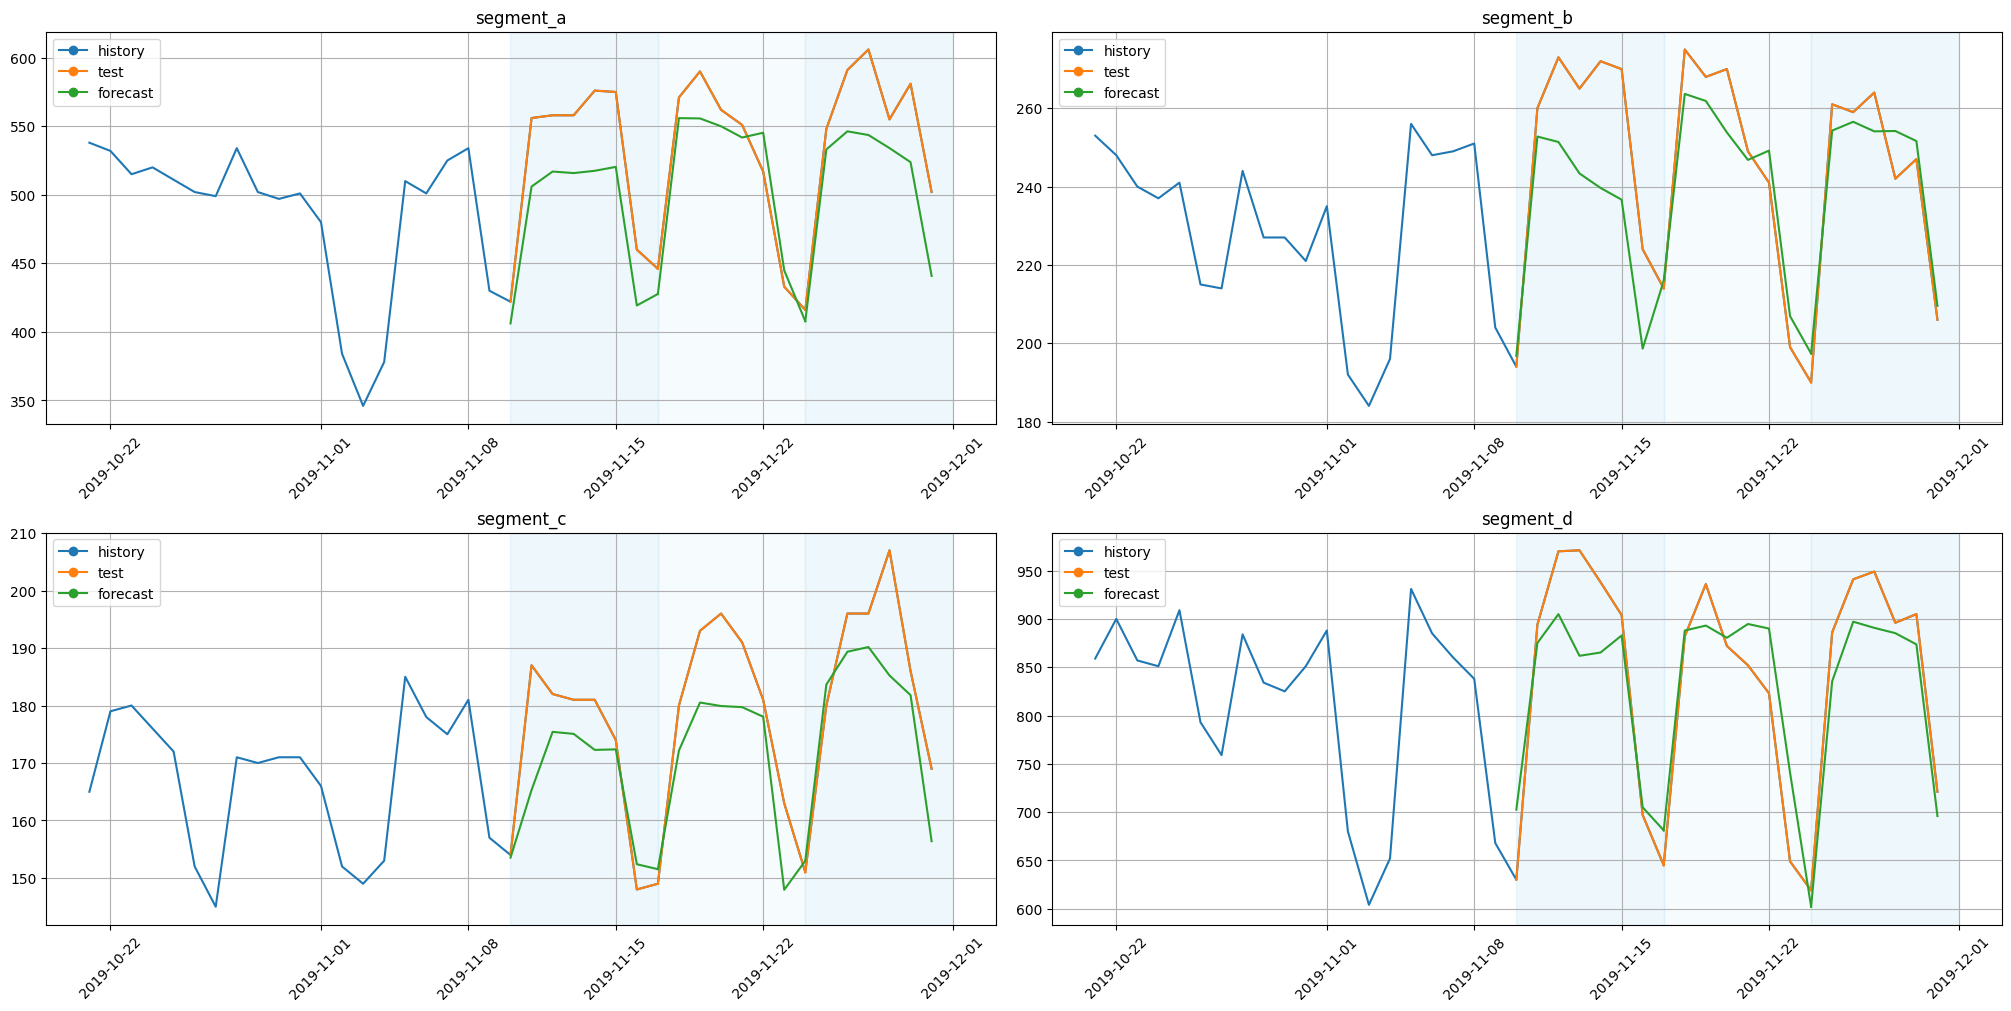

In [ ]:
plot_backtest(forecast_deepar, ts, history_len=20)